In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df_original = df

In [4]:
df.shape #check the number of rows and cols

(40277, 31)

In [5]:
df.info() #checking the types of the data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

In [6]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [7]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [8]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [9]:
df['calendardate'] = pd.to_datetime(df['calendardate'])
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [10]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321467,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504182,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299008571,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710498,0.099426,0.427586,7.010309,1.933891,0.195735


In [11]:
#converting operating margin to a numerical data, apparently there's a bad data, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

<ipython-input-11-696f7acdccde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA


In [12]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ'])] #can drop quick_ratio or drop HTZ, GE

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,...,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,...,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [13]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [14]:
df = df.dropna() #dropping the null values

In [15]:
df.info() #check for infinity how many rows where dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 1 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1493 non-null   object        
 1   revenue                  1493 non-null   float64       
 2   pb                       1493 non-null   float64       
 3   debt                     1493 non-null   float64       
 4   assets                   1493 non-null   float64       
 5   netmargin                1493 non-null   float64       
 6   ncfo                     1493 non-null   float64       
 7   shareswa                 1493 non-null   float64       
 8   sps                      1493 non-null   float64       
 9   opinc                    1493 non-null   float64       
 10  assetsc                  1493 non-null   float64       
 11  liabilitiesc             1493 non-null   float64       
 12  price                    1493 non

In [16]:
#df['calendardate']
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-1.454370e+08,-2.319,7.288,-0.409374,-39.292488,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,...,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,...,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,...,-6.374200e+07,0.153,22.487,-0.103884,-0.299009,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735


drop_cols = ['datekey', 'calendardate', 'TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'OPER_MARGIN', 'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'ticker']
df.drop(columns = drop_cols, inplace=True)


In [17]:
df.isna().sum() #no nulls 

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [18]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'OPER_MARGIN', 'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks.

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
1,0.018688,-19.603277,0.047655,-0.922987,-39.292488,-0.409374,7.288,3.647265,2.456810e+08,-38.489
16,0.195382,-65.555556,0.621846,0.035415,-0.347321,-0.243414,10.140,1.454003,1.646590e+08,-0.337
30,0.572629,47.403295,3.514597,1.221921,0.294504,0.134270,23.279,1.672204,2.708000e+09,0.229
51,0.050918,366.601307,0.791419,0.042444,-0.299009,-0.103884,22.487,1.579705,3.191640e+08,-0.288
65,0.195735,7.010309,0.427586,0.099426,0.010710,0.012826,2.931,1.933891,1.975430e+09,-0.009


In [19]:
df.corr() #check the correlation between features

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,OPER_MARGIN,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,-0.009748,0.005964,0.021061,0.069597,0.094259,-0.045669,-0.169095,0.004443,0.066201
PX_FREE_CASH_FLOW,-0.009748,1.000000,-0.004659,-0.004172,0.006953,0.051876,0.011290,0.024979,-0.002127,0.006396
REVENUE_PER_SHARE,0.005964,-0.004659,1.000000,0.892506,0.011968,0.035092,-0.003294,-0.037426,0.815309,0.010660
CASH_FLOW_PER_SHARE,0.021061,-0.004172,0.892506,1.000000,0.021760,0.094722,-0.006566,-0.053225,0.889748,0.019044
OPER_MARGIN,0.069597,0.006953,0.011968,0.021760,1.000000,0.285012,-0.006289,-0.129486,0.002986,0.900705
RETURN_ON_ASSET,0.094259,0.051876,0.035092,0.094722,0.285012,1.000000,-0.017569,-0.133204,0.007883,0.258953
PX_TO_BOOK_RATIO,-0.045669,0.011290,-0.003294,-0.006566,-0.006289,-0.017569,1.000000,0.005273,-0.001863,-0.005069
quick_ratio,-0.169095,0.024979,-0.037426,-0.053225,-0.129486,-0.133204,0.005273,1.000000,-0.007829,-0.182241
equity,0.004443,-0.002127,0.815309,0.889748,0.002986,0.007883,-0.001863,-0.007829,1.000000,0.002667
netmargin,0.066201,0.006396,0.010660,0.019044,0.900705,0.258953,-0.005069,-0.182241,0.002667,1.000000


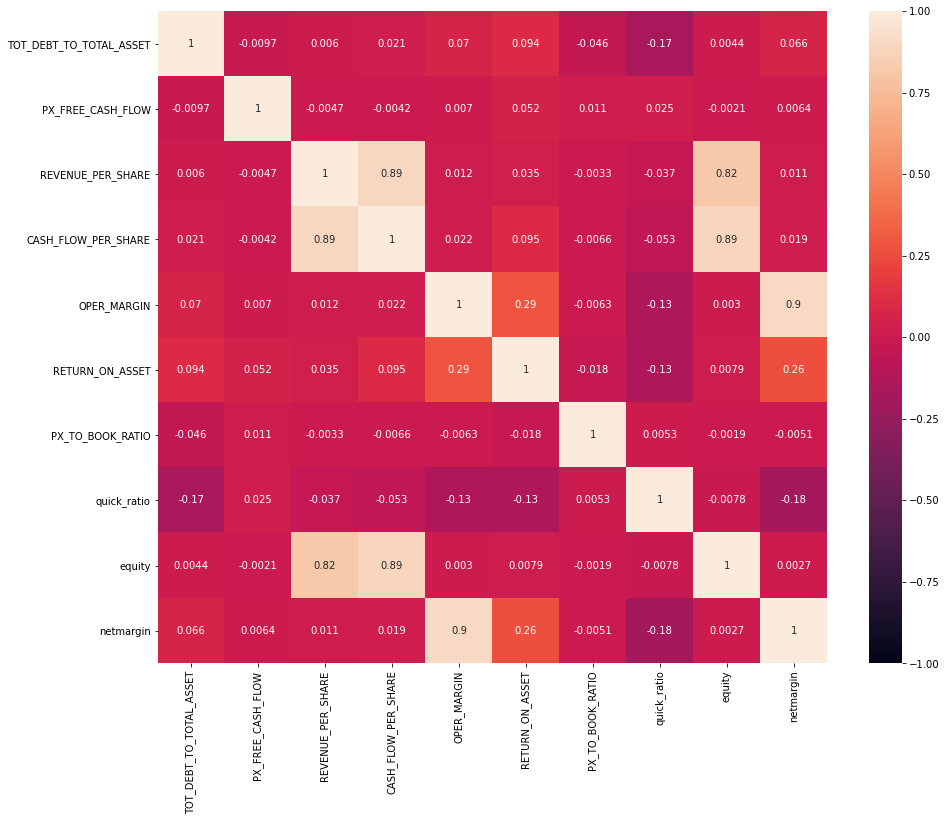

In [20]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [21]:
#dropping the highly correlated columns 

drop_cols = ['equity', 'REVENUE_PER_SHARE', 'OPER_MARGIN']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
1,0.018688,-19.603277,-0.922987,-0.409374,7.288,3.647265,-38.489
16,0.195382,-65.555556,0.035415,-0.243414,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,0.134270,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,-0.103884,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009


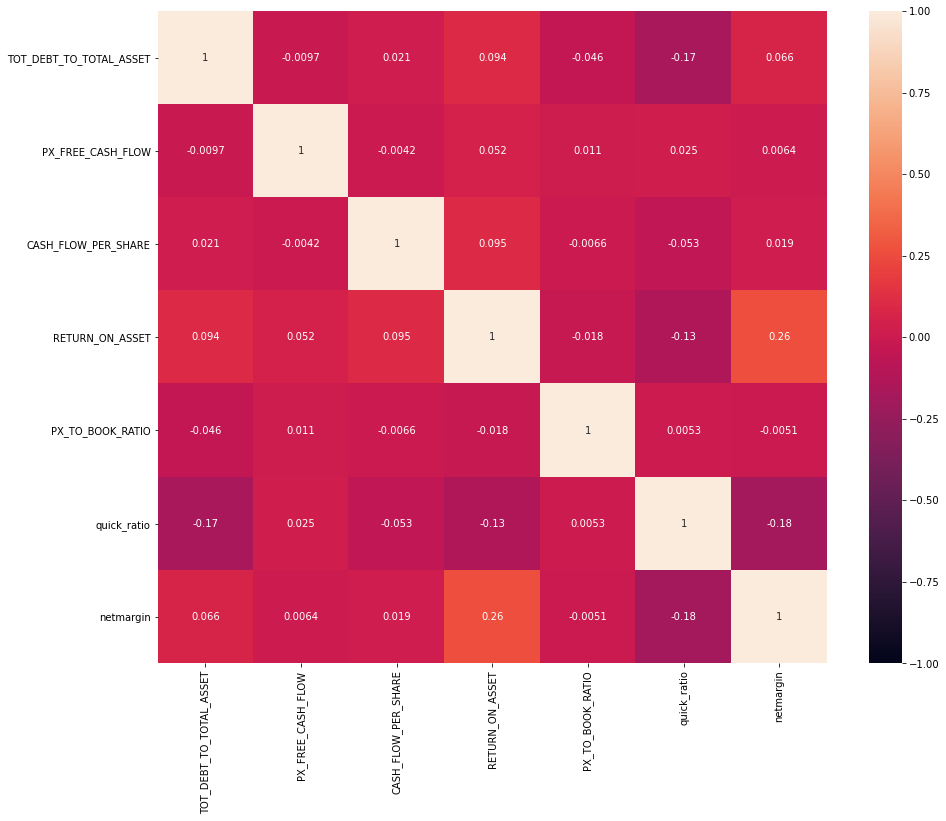

In [22]:
#now the data seems clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [23]:
#assigning X, y
X = df #clean data
y = df_original

In [24]:
y

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8.269000e+06,3.091,9.007000e+06,6.365780e+08,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7.860000e+06,3.146,6.755000e+06,4.000370e+08,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7.882000e+06,2.112,7.829000e+06,4.145470e+08,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,1.192500e+07,3.048,8.065000e+06,2.382790e+08,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40272,A,1.019000e+09,3.223,1.889000e+09,7.640000e+09,0.089,254000000.0,326000000.0,3.126,131000000.0,...,463000000.0,1.859,3.223,0.062416,0.128557409,0.774933,3.108887,22.011834,2.419241,0.247251
40273,A,1.028000e+09,3.092,1.733000e+09,7.302000e+09,0.118,111000000.0,329000000.0,3.125,155000000.0,...,459000000.0,1.675,3.092,0.062356,0.15077821,0.334165,3.094793,22.477612,2.690602,0.237332
40274,A,1.035000e+09,3.003,1.655000e+09,7.479000e+09,0.135,241000000.0,330000000.0,3.136,156000000.0,...,401000000.0,1.279,3.003,0.054078,0.150724638,0.727211,3.123084,29.523065,2.921107,0.221286
40275,A,1.014000e+09,3.325,1.655000e+09,7.251000e+09,0.109,108000000.0,332000000.0,3.054,144000000.0,...,329000000.0,1.060,3.325,0.039882,0.142011834,0.324138,3.043293,38.632075,3.117233,0.228244


In [25]:
X

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
1,0.018688,-19.603277,-0.922987,-0.409374,7.288,3.647265,-38.489
16,0.195382,-65.555556,0.035415,-0.243414,10.140,1.454003,-0.337
30,0.572629,47.403295,1.221921,0.134270,23.279,1.672204,0.229
51,0.050918,366.601307,0.042444,-0.103884,22.487,1.579705,-0.288
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009
...,...,...,...,...,...,...,...
40154,0.245764,18.533474,2.286520,0.043565,3.090,0.247478,0.045
40175,0.000000,42.303082,0.524823,0.155083,8.872,1.995449,0.131
40217,0.557446,-31.481888,1.369682,0.027648,-106.470,0.313145,0.037
40238,0.123026,13.004837,1.411844,-0.074250,0.971,0.600468,-0.124


In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [27]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
1,-1.332430,-0.121285,-0.366878,-2.779675,0.044212,0.509192,-0.367756
16,-0.582976,-0.261231,-0.244802,-1.698691,0.089654,-0.133049,0.057100
30,1.017127,0.082780,-0.093673,0.761365,0.299004,-0.069155,0.063402
51,-1.195727,1.054883,-0.243907,-0.789859,0.286385,-0.096241,0.057645
65,-0.581480,-0.040235,-0.236649,-0.029665,-0.025210,0.007474,0.060752


k_means = KMeans(n_clusters=2, random_state=55)
%timeit k_means.fit(df)
y = k_means.predict(df)

# Plot the solution.
plt.scatter(df[:,0], df[:,1], c=y)
plt.show()

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled)
#computing the first principal component

In [29]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

pca = PCA(n_components=8).fit_transform(X)

plt.figure(figsize=(10,5))
colours = 'rbg'

fontdict={'weight': 'bold', 'size': 50}

plt.show()

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    scaled,
    X_pca,
    test_size=0.5,
    random_state=13579)

ypred = pd.DataFrame()

for counter, data in enumerate([ 
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = df[0][:, 0] #somewhere here is the error
    ypred['pca_f2' + '_sample' + str(counter)] = df[0][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=55).fit_predict(df[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        
         # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

In [31]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

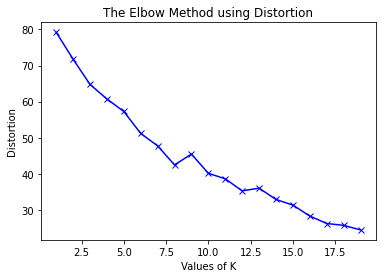

In [32]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [33]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[0 0 0 ... 0 0 0]


In [34]:
pd.Series(kmeans.labels_).value_counts() #number of stocks in clusters
#tried numbers from 7 to 11, chose 8

0    1404
6      44
7      29
4       8
5       2
3       2
2       2
1       2
dtype: int64

In [35]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters
df['label'] = df['label'].astype(str)

In [36]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    #shows the highest 

In [37]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.337460,18.797029,2.045011,0.021510,4.140083,1.857255,-2.707152
1,0.050844,5871.484019,0.258723,-0.035342,14.746000,6.220106,0.005000
2,0.208691,-4346.000000,0.151016,-0.172299,-12.582000,0.478687,-0.040500
3,0.149101,3307.111111,0.323432,-0.046888,6.547500,1.788574,0.016500
4,0.201143,-1299.344666,0.718775,-0.031639,5.613625,2.238599,-0.118875
5,0.038027,-16.356618,-0.223490,-0.503689,4.711000,15.797225,-2187.565000
6,0.246666,-250.389384,0.717502,-0.052649,12.367750,2.665884,0.427182
7,0.336594,537.219073,0.440270,-0.005676,10.675517,1.994138,-0.013586


In [38]:
from sklearn import preprocessing

In [39]:
df['label'] = kmeans.labels_ 
#df['label'] = df['label'].astype(str)

In [40]:
#normalizing the data for a better and easier understanding of the differences between clusters
#MinMax scaler puts from 0-1

df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0))) 
df['label'] = kmeans.labels_

In [41]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.107206,0.458742,0.034641,0.741239,0.598513,0.022741,0.990211
1,0.016152,0.963342,0.027633,0.713919,0.602942,0.077227,0.991231
2,0.066298,0.082423,0.027210,0.648107,0.591529,0.005525,0.991214
3,0.047367,0.742250,0.027887,0.708371,0.599518,0.021884,0.991235
4,0.063900,0.345096,0.029438,0.715699,0.599128,0.027504,0.991184
5,0.012081,0.455711,0.025741,0.488862,0.598751,0.196830,0.169014
6,0.078362,0.435534,0.029433,0.705603,0.601949,0.032840,0.991390
7,0.106931,0.503439,0.028345,0.728175,0.601242,0.024451,0.991224


#outliers = winsorize them, or remove for now or replace with 0
from scipy.stats.mstats import winsorize

df = df(winsorize('netmargin'))

In [45]:
from scipy.stats.mstats import winsorize

In [46]:
df = np.array(['netmargin']) #winsorizing the netmargin, cuz it's very high in value, almost all the data. 

In [58]:
winsorize(df, limits=[0.1, 0.2])


masked_array(data=['netmargin'],
             mask=False,
       fill_value='N/A',
            dtype='<U9')

In [61]:
df = pd.DataFrame.fillna([[np.nan, 2, np.nan, 0]], columns=list('netmargin'))

TypeError: super(type, obj): obj must be an instance or subtype of type

In [48]:
import matplotlib.pyplot as plt

plt.hist(df['netmargin'], bins = 60)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
df_copy['netmargin']

In [ ]:

#df_copy = df_copy.drop(columns='label')

In [ ]:
#df = df.drop([1])

#transforming object into numerical category
13 = LabelEncoder()
label = 13.fit_transform(df_copy['label'])
data = df_copy.drop('sex', axis = 'columns')
data['label'] = label

In [ ]:
#df.info()

In [ ]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,5))
colours = 'rbg'


plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
sns.scatterplot(x=pca[:, 0], y = pca[:, 1], hue = df['label'])


In [ ]:
#make normalized numbers for clustering then the absolute numbers. Take averages of normalized numbers. 

#converting label categorical number to a numeric value
df_copy['label'] = df_copy['label'].astype(str)

df_copy['label'] = df_copy['label'].str.replace('\D', '').astype(int)

df_copy.info()

#winsorize, pca, visuals for clusters = each group, performance with rand_index, 
#winsorize
PCA and get the visuals for each group
Performance of your clusteing adjusted rand index
GAUSSIAN
if i have time NON-linearity check it out, TSNE. reduce the data to 2, visualize, cluster. 

explain with small clusters. 

In [ ]:
df[df['label'] == 2] #filtered to row number 1 (cluster) #6 revenue per share is high 9-quick ratio, price for 
#cash flow is high too. #cash flow, quick ratio is okay, #10 is negative but not much debt, all therapies

#netmargin, oper margin 

In [ ]:
df.info()

In [ ]:
df_copy.info()

In [ ]:
pd.Series(kmeans.labels_).value_counts() 

In [ ]:
df[df['label'] == 3] #normalized data easy to compare among clusters

In [ ]:
df[df['label'] == 1] 

In [ ]:
df[df['label'] == 5] 

In [ ]:
df[df['label'] == 7]  #profitable and cheap but have higher debt

In [ ]:
df[df['label'] == 4] #cheaper than 7, no cash flow, profitable = oper margin, not diff with 7 but cheap, good for investments

In [ ]:
df[df['label'] == 6] #cost is higher = px free cash flow, 

In [ ]:
df[df['label'] == 0] 

In [ ]:
df.plot
plt.hist

PCA ON KMENS DO IT
NORMALIZED ON GAUSSIANMIXTURE TOO
THEN PCA ON GAUSSIAN


In [ ]:
gauss = GaussianMixture(n_components=5, random_state=55)
gauss.fit(X)

In [ ]:
gauss.means_

In [ ]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

In [ ]:
centroids = df_copy.groupby(['new_label']).mean()

In [ ]:
centroids.style.background_gradient() 

In [ ]:
df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0)))

In [ ]:
gauss = GaussianMixture(n_components=5, random_state=55)
gauss.fit(X)

In [ ]:
gauss.predict(X)

In [ ]:
df['label'] = gauss.predict(X)

In [ ]:
centroids = df.groupby(['label']).mean()

In [ ]:
centroids.style.background_gradient() 

In [ ]:
scipy.stats.entropy([0.731826, 0.267606, 5.687710e-04])


In [ ]:
prob_df['entropy'] = prob_df.apply(scipy.stats.entropy, axis=1)

In [ ]:
prob_df.sort_values('entropy')

In [ ]:
#df_copy

In [ ]:
df_copy = df_copy.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0)))

In [ ]:

px.scatter(data_frame=df_copy, x='TOT_DEBT_TO_TOTAL_ASSET', y='PX_TO_BOOK_RATIO', color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])

In [ ]:
from ipywidgets import interact

In [ ]:
#probably can work in collab, notebook in slides Friday, code for collab there. 

@interact
def plotting(x=df_copy.columns, y = df_copy.columns):
    fig = px.scatter(data_frame=df_copy, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

In [ ]:
#choose two dimensions pairplot with two variable and see the cluster = label
#show the differences on clusters.

find a plot where i can see distinct clusters.

In [ ]:
set(y_pred) #no repeated list = set

In [ ]:
df.info()

In [ ]:
df['OPER_MARGIN'].unique()

In [ ]:
#df['OPER_MARGIN'] = df['OPER_MARGIN'].str.replace('\', '').astype(int)

In [ ]:
#df['OPER_MARGIN'] = float('OPER_MARGIN')

In [ ]:
#float("OPER_MARGIN")

In [ ]:
df.['OPER_MARGIN']['6']

Keep the following considerations in mind: How do clustering and modeling compare? (Kmeans,Gaussian) two different results and whats best and worst. 
What are the advantages of each? Why would you want to use one over the other?

 Jupyter's built-in slide deck capabilities.
 
 
The visuals that you chose and what they represent for your research
Next steps that you'd take to expand on your work - visuals and next i tell what to do with this, groups of similar stocks: long, short, quick, data trade clusters. Make names for clusters on their similarities. 

A specified research question that your model addresses - can we group stocks? think of it.

How you chose your model specification and what alternatives you compared it to

In [ ]:
#opinc = operating income


In [ ]:
#scaler = StandardScaler() #to make the mean 0 and std = 1
scaler = MinMaxScaler() #max - 1 min = 0
scaled = scaler.fit_transform(df)



In [ ]:
scaled_df = pd.DataFrame(scaled, columns=df.columns)
scaled_df.head()

In [ ]:
#standardscale

In [ ]:
#scaled_df = scale(df)

In [ ]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)


In [ ]:
fORMAL WAYS TO EVALUATING CLUSTERS. RAND INDEX